<a href="https://colab.research.google.com/github/SMN-SENAMHI/MONITOREO/blob/main/ERA5_SURFACE_MONTH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install -q xarray zarr "fsspec<=2025.3.0" "requests==2.32.4"


In [21]:
# ==============================================
# Guardar token en Colab (.netrc)
# ==============================================

#Reemplaza con tu token segun usuario registrado
TOKEN = "edh_pat_cfdba8b50c493e84dfc676f5f1efed1794dde11c40cd21237e54c21da72c2f9378c792defeb8e2ca4638ac478df26ab8"

# Crear el archivo .netrc en /root
with open("/root/.netrc", "w") as f:
    f.write("machine data.earthdatahub.destine.eu\n")
    f.write(f"  password {TOKEN}\n")

# Ajustar permisos (requerido por seguridad)
!chmod 600 /root/.netrc


In [ ]:
import xarray as xr
import pandas as pd

# -----------------------------
# 1. Abrir dataset ERA5
# -----------------------------
url = "https://data.earthdatahub.destine.eu/era5/reanalysis-era5-single-levels-monthly-means-v0.zarr"

ds = xr.open_dataset(
    url,
    engine="zarr",
    chunks="auto",
    storage_options={"client_kwargs": {"trust_env": True}}
)

# -----------------------------
# 2. Variables con unidades y descripción
# -----------------------------
variables = []
for var in ds.data_vars:
    units = ds[var].attrs.get("units", "sin unidades")
    long_name = ds[var].attrs.get("long_name", "sin descripción")
    variables.append([var, units, long_name])

df = pd.DataFrame(variables, columns=["Variable", "Unidades", "Descripción"])
print("Variables disponibles en ERA5:\n")
print(df.to_string(index=False))

# -----------------------------
# 3. Rango temporal del dataset
# -----------------------------
fechas = pd.to_datetime(ds.valid_time.values)
inicio = fechas.min().strftime("%Y-%m")
fin    = fechas.max().strftime("%Y-%m")

print("\n Rango temporal del dataset ERA5:")
print(f"Inicio: {inicio}")
print(f"Fin:    {fin}")
print(f"Total de meses: {len(fechas)}")



Variables disponibles en ERA5:

Variable Unidades                  Descripción
     d2m        K 2 metre dewpoint temperature
     msl       Pa      Mean sea level pressure
      sp       Pa             Surface pressure
     sst        K      Sea surface temperature
     t2m        K          2 metre temperature
      tp        m          Total precipitation
     u10  m s**-1    10 metre U wind component
     v10  m s**-1    10 metre V wind component

 Rango temporal del dataset ERA5:
Inicio: 1940-01
Fin:    2025-07
Total de meses: 1027


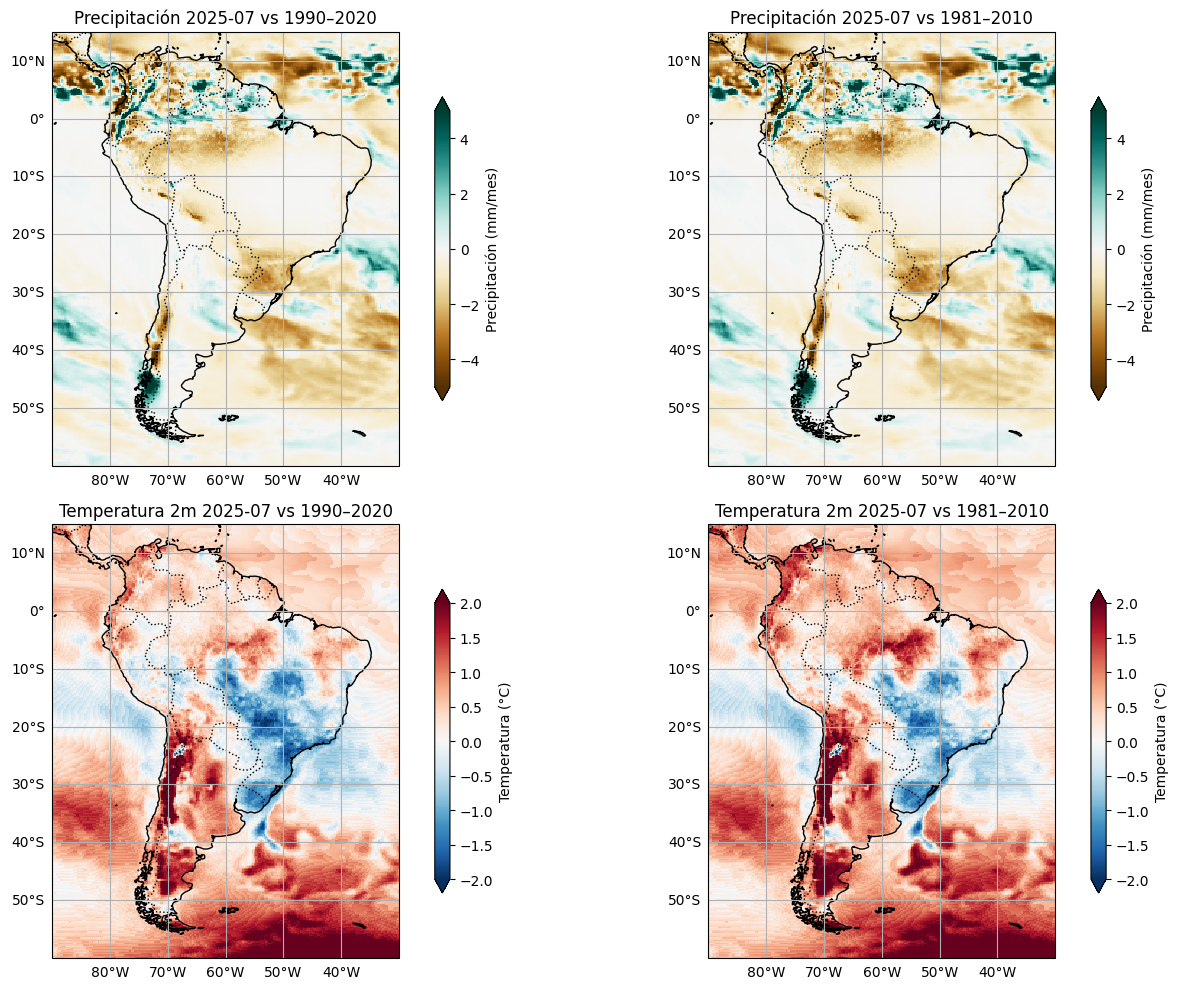

In [29]:
# ============================================
# 1. Instalar dependencias (solo en Colab)
# ============================================
#!apt-get install -y libproj-dev proj-data proj-bin libgeos-dev
!pip install -q cartopy xarray zarr fsspec requests

# ============================================
# 2. Importar librerías
# ============================================
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# ============================================
# 3. Definir fecha de análisis
# ============================================
fecha_analisis = "2025-07"   # AAAA-MM
anio, mes = fecha_analisis.split("-")
mes = int(mes)  # para climatologías

# ============================================
# 4. Abrir dataset ERA5 (requiere token en .netrc)
# ============================================
url = "https://data.earthdatahub.destine.eu/era5/reanalysis-era5-single-levels-monthly-means-v0.zarr"

ds = xr.open_dataset(
    url,
    engine="zarr",
    chunks="auto",
    storage_options={"client_kwargs": {"trust_env": True}}
)

# ============================================
# 5. Recorte geográfico (ejemplo: Sudamérica / país)
# ============================================
# Sudamérica completo
lat_min, lat_max = -60, 15
lon_min, lon_max = 270, 330   # (-90 a -30 en 0–360)

# Perú
#lat_min, lat_max = -20, 1
#lon_min, lon_max = 278, 292   # (-82 a -68)

# Colombia
#lat_min, lat_max = -5, 13
#lon_min, lon_max = 281, 294   # (-79 a -66)

# Ecuador
#lat_min, lat_max = -5, 2
#lon_min, lon_max = 279, 285   # (-81 a -75)

# Chile
#lat_min, lat_max = -55, -17
#lon_min, lon_max = 285, 293   # (-75 a -67)

# Argentina
#lat_min, lat_max = -55, -21
#lon_min, lon_max = 287, 307   # (-73 a -53)

# Brasil
#lat_min, lat_max = -34, 5
#lon_min, lon_max = 286, 326   # (-74 a -34)

# ============================================
# 6. Seleccionar variables
# ============================================
# Precipitación total (m → mm)
tp = ds["tp"] * 1000
tp.attrs["units"] = "mm/mes"

# Temperatura 2m (K → °C)
t2m = ds["t2m"] - 273.15
t2m.attrs["units"] = "°C"

# Recortes
tp_sel  = tp.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
t2m_sel = t2m.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))

# ============================================
# 7. Seleccionar mes de análisis
# ============================================
tp_target  = tp_sel.sel(valid_time=fecha_analisis)
t2m_target = t2m_sel.sel(valid_time=fecha_analisis)

# ============================================
# 8. Climatologías
# ============================================
# Precipitación
clim_tp_1990_2020 = tp_sel.sel(valid_time=slice("1990-01", "2020-12"))
clim_tp_1990_2020_mes = clim_tp_1990_2020.sel(valid_time=clim_tp_1990_2020["valid_time"].dt.month == mes)
clim_tp_1990_2020_mean = clim_tp_1990_2020_mes.mean("valid_time")

clim_tp_1981_2010 = tp_sel.sel(valid_time=slice("1981-01", "2010-12"))
clim_tp_1981_2010_mes = clim_tp_1981_2010.sel(valid_time=clim_tp_1981_2010["valid_time"].dt.month == mes)
clim_tp_1981_2010_mean = clim_tp_1981_2010_mes.mean("valid_time")

# Temperatura
clim_t2m_1990_2020 = t2m_sel.sel(valid_time=slice("1990-01", "2020-12"))
clim_t2m_1990_2020_mes = clim_t2m_1990_2020.sel(valid_time=clim_t2m_1990_2020["valid_time"].dt.month == mes)
clim_t2m_1990_2020_mean = clim_t2m_1990_2020_mes.mean("valid_time")

clim_t2m_1981_2010 = t2m_sel.sel(valid_time=slice("1981-01", "2010-12"))
clim_t2m_1981_2010_mes = clim_t2m_1981_2010.sel(valid_time=clim_t2m_1981_2010["valid_time"].dt.month == mes)
clim_t2m_1981_2010_mean = clim_t2m_1981_2010_mes.mean("valid_time")

# ============================================
# 9. Anomalías
# ============================================
anom_tp_1990_2020  = tp_target  - clim_tp_1990_2020_mean
anom_tp_1981_2010  = tp_target  - clim_tp_1981_2010_mean
anom_t2m_1990_2020 = t2m_target - clim_t2m_1990_2020_mean
anom_t2m_1981_2010 = t2m_target - clim_t2m_1981_2010_mean

# ============================================
# 10. Graficar con Cartopy
# ============================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10),
                         subplot_kw={"projection": ccrs.PlateCarree()})

# Configuración común
for ax in axes.flat:
    ax.set_extent([lon_min-360, lon_max-360, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.coastlines(resolution="50m")
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.4)
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False

# Precipitación (BrBG, -5 a +5 mm/mes)
anom_tp_1990_2020.plot(
    ax=axes[0,0], transform=ccrs.PlateCarree(),
    cmap="BrBG", vmin=-5, vmax=5,
    cbar_kwargs={"label": "Precipitación (mm/mes)", "shrink": 0.7}
)
axes[0,0].set_title(f"Precipitación {fecha_analisis} vs 1990–2020")

anom_tp_1981_2010.plot(
    ax=axes[0,1], transform=ccrs.PlateCarree(),
    cmap="BrBG", vmin=-5, vmax=5,
    cbar_kwargs={"label": "Precipitación (mm/mes)", "shrink": 0.7}
)
axes[0,1].set_title(f"Precipitación {fecha_analisis} vs 1981–2010")

# Temperatura (RdBu_r, -2 a +2 °C)
anom_t2m_1990_2020.plot(
    ax=axes[1,0], transform=ccrs.PlateCarree(),
    cmap="RdBu_r", vmin=-2, vmax=2,
    cbar_kwargs={"label": "Temperatura (°C)", "shrink": 0.7}
)
axes[1,0].set_title(f"Temperatura 2m {fecha_analisis} vs 1990–2020")

anom_t2m_1981_2010.plot(
    ax=axes[1,1], transform=ccrs.PlateCarree(),
    cmap="RdBu_r", vmin=-2, vmax=2,
    cbar_kwargs={"label": "Temperatura (°C)", "shrink": 0.7}
)
axes[1,1].set_title(f"Temperatura 2m {fecha_analisis} vs 1981–2010")

plt.tight_layout()
plt.show()
